**Imports des données**

In [32]:
import numpy as np
import json
import pprint
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

filename_path = 'data/df.csv'
df = pd.read_csv(filename_path)

**Parametres divers**

In [33]:
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_colwidth', 100)

**Choix des prédicteurs**   

In [34]:
all_columns = [
    'DataYear',
    'BuildingType',
    'PrimaryPropertyType',
    'CouncilDistrictCode',
    'Neighborhood',
    'YearBuilt',
    'NumberofBuildings',
    'NumberofFloors',
    'PropertyGFATotal',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)',
    'LargestPropertyUseType',
    'LargestPropertyUseTypeGFA',
    'SecondLargestPropertyUseTypeGFA',
    'ThirdLargestPropertyUseTypeGFA',
    'SiteEnergyUseWN(kBtu)',
    'GHGEmissions(MetricTonsCO2e)',
    'ENERGYSTARScore']

In [35]:
"""predicators_columns = [
    'DataYear',
    'BuildingType',
    'PrimaryPropertyType',
    'CouncilDistrictCode',
    'Neighborhood',
    'YearBuilt',
    'NumberofBuildings',
    'NumberofFloors',
    'PropertyGFATotal',
    'PropertyGFAParking',
    'PropertyGFABuilding(s)',
    'LargestPropertyUseType',
    'LargestPropertyUseTypeGFA',
    'SecondLargestPropertyUseTypeGFA',
    'ThirdLargestPropertyUseTypeGFA']"""

predicators_columns = [
    'NumberofBuildings',
    'PropertyGFATotal',
    'GHGEmissions(MetricTonsCO2e)']

target_columns = [
    'SiteEnergyUseWN(kBtu)','GHGEmissions(MetricTonsCO2e)']

X = df.loc[:, predicators_columns]
y = df.loc[:, target_columns[0]]

**Separation du jeux de données pour l'entrainement puis l'évaluation**

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

**Preprocessing**

*Détection des valeurs aberrantes ( Outlier Detection )*

In [37]:
from sklearn.neighbors import LocalOutlierFactor

local_outlier_factor = LocalOutlierFactor(n_neighbors=20, contamination=0.05)

labels = local_outlier_factor.fit_predict(X_train)

X_scores = local_outlier_factor.negative_outlier_factor_

print(f'Nombre d\'outliers : {np.count_nonzero(labels == -1)}')
print(f'Nombre d\'inliers : {np.count_nonzero(labels == 1)}')

X_train = X_train[labels == 1]
y_train = y_train[labels == 1]

Nombre d'outliers : 254
Nombre d'inliers : 4814


*Mise à l'échelle ( Feature scaling )*

In [38]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

standard_scaler_X = StandardScaler().fit(X_train)

X_train = standard_scaler_X.transform(X_train)
X_test = standard_scaler_X.transform(X_test)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

### Modélisations sans validation croisée

**0) Régression Baseline**

In [39]:
from sklearn.dummy import DummyRegressor

dummy_regression = DummyRegressor(strategy="mean")
dummy_regression.fit(X_train,y_train)

DummyRegressor()

In [40]:
print('score mse: ', np.mean((dummy_regression.predict(X_test) - y_test) ** 2))
print('score r2: ', dummy_regression.score(X_test, y_test))

score mse:  164454651327194.53
score r2:  -5.789862244753863e-06


**1) Régression Linéaire**

In [41]:
from sklearn.linear_model import LinearRegression

linear_regression = LinearRegression()
linear_regression.fit(X_train,y_train)

LinearRegression()

In [42]:
print('score mse: ', np.mean((linear_regression.predict(X_test) - y_test) ** 2))
print('score r2: ', linear_regression.score(X_test, y_test))

score mse:  13643555452734.049
score r2:  0.9170371021012009


**2) Régression Ridge**

In [43]:
from sklearn.linear_model import Ridge

ridge_regression = Ridge()

n_alphas = 200
alphas = np.logspace(-5, 5, n_alphas)
coefs = []
errors = []
for a in alphas:
    ridge_regression.set_params(alpha=a)
    ridge_regression.fit(X_train, y_train)
    coefs.append(ridge_regression.coef_.flatten())
    errors.append(np.mean((ridge_regression.predict(X_test) - y_test) ** 2))

In [44]:
alpha_min = alphas[np.argmin(errors)]
ridge_regression.set_params(alpha=alpha_min)
ridge_regression.fit(X_train, y_train)

print('score mse: ', np.mean((ridge_regression.predict(X_test) - y_test) ** 2))
print('score r2: ', ridge_regression.score(X_test, y_test))

score mse:  11791430579552.785
score r2:  0.9282993898004657


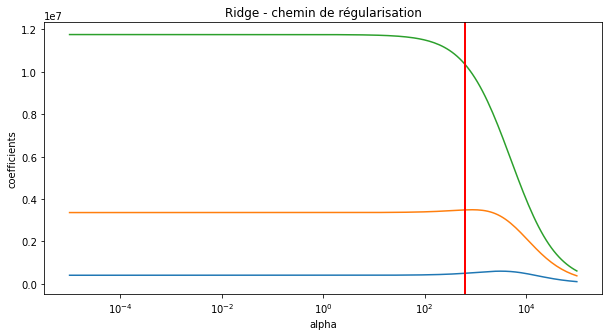

In [45]:
# Affiche le chemin de régularisation
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(alphas, coefs)

plt.axvline(x=alpha_min,linewidth=2, color='r')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.title('Ridge - chemin de régularisation')
plt.axis('tight')
plt.show()

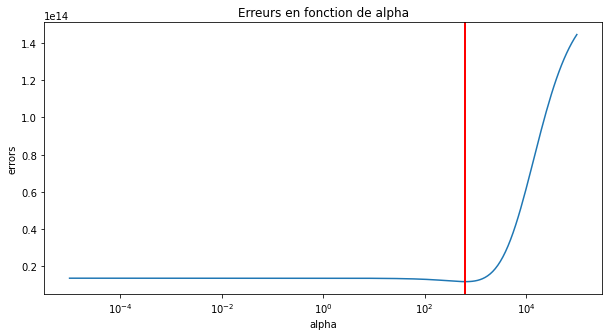

In [46]:
# Affiche la courbe d'erreurs en fonction de la régularisation
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(alphas, errors)

plt.axvline(x=alpha_min,linewidth=2, color='r')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('errors')
plt.title('Erreurs en fonction de alpha')
plt.axis('tight')
plt.show()

**3) Régression Lasso**

In [47]:
from sklearn.linear_model import Lasso

n_alphas = 300
alphas = np.logspace(-5, 10, n_alphas)
lasso_regression = Lasso(fit_intercept=False)

coefs = []
errors = []
for a in alphas:
    lasso_regression.set_params(alpha=a)
    lasso_regression.fit(X_train, y_train)
    coefs.append(lasso_regression.coef_.flatten())
    errors.append(np.mean((lasso_regression.predict(X_test) - y_test) ** 2))

In [48]:
alpha_min = alphas[np.argmin(errors)]
lasso_regression.set_params(alpha=alpha_min)
lasso_regression.fit(X_train, y_train)

print('score mse: ', np.mean((lasso_regression.predict(X_test) - y_test) ** 2))
print('score r2: ', lasso_regression.score(X_test, y_test))

score mse:  36275010800668.47
score r2:  0.7794211319945477


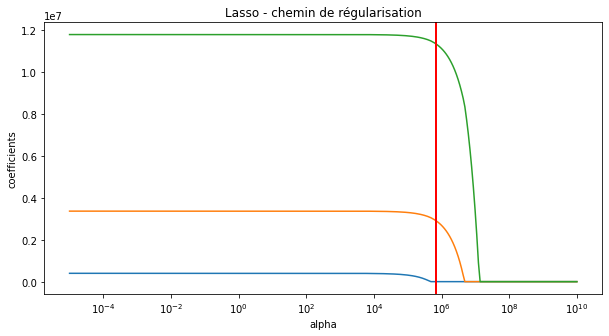

In [49]:
# Affiche le chemin de régularisation
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(alphas, coefs)
plt.axvline(x=alpha_min,linewidth=2, color='r')

plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.title('Lasso - chemin de régularisation')
plt.axis('tight')
plt.show()

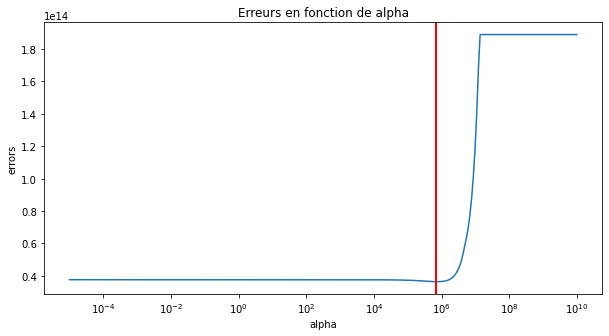

In [50]:
# Affiche la courbe d'erreurs en fonction de la régularisation
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(alphas, errors)

plt.axvline(x=alpha_min,linewidth=2, color='r')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('errors')
plt.title('Erreurs en fonction de alpha')
plt.axis('tight')
plt.show()

**4) Elastic Net**

In [51]:
from sklearn.linear_model import ElasticNet

n_alphas = 300
alphas = np.logspace(-5, 10, n_alphas)
elasticnet_regression = ElasticNet(l1_ratio=0.5 , max_iter=10000, fit_intercept=False)

coefs = []
errors = []
for a in alphas:
    elasticnet_regression.set_params(alpha=a)
    elasticnet_regression.fit(X_train, y_train)
    coefs.append(elasticnet_regression.coef_.flatten())
    errors.append(np.mean((elasticnet_regression.predict(X_test) - y_test) ** 2))

In [52]:
alpha_min = alphas[np.argmin(errors)]
elasticnet_regression.set_params(alpha=alpha_min)
elasticnet_regression.fit(X_train, y_train)

print('score mse: ', np.mean((elasticnet_regression.predict(X_test) - y_test) ** 2))
print('score r2: ', elasticnet_regression.score(X_test, y_test))

score mse:  35737510682457.57
score r2:  0.7826895298533174


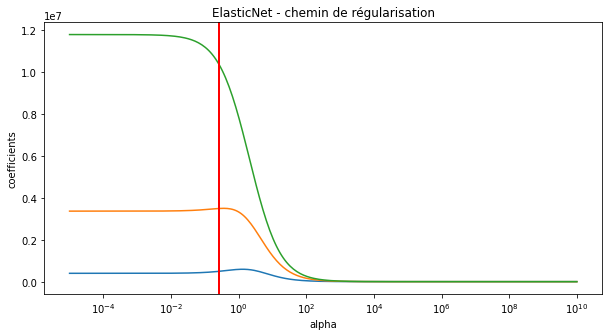

In [53]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(alphas, coefs)

plt.axvline(x=alpha_min,linewidth=2, color='r')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('coefficients')
plt.title('ElasticNet - chemin de régularisation')
plt.axis('tight')
plt.show()

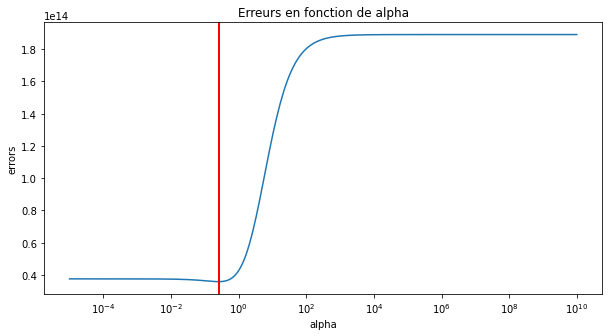

In [54]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(alphas, errors)

plt.axvline(x=alpha_min,linewidth=2, color='r')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('errors')
plt.title('Erreurs en fonction de alpha')
plt.axis('tight')
plt.show()

### Modélisations avec validation croisée
Mise en place de la validation croisée et d'une méthode d'optimisation à l'aide d'une grille paramétrable

**5) GridSearchCV - Régression Linéaire**

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

# Création du modele linéaire
linear_regression = LinearRegression()

# Création du dictionnaire d'hyperparamètres
hyperparameters = dict()

# Création d'une recherche par grille paramétrable utilisant une validation croisée de 5 plis (K-Fold) et nos hyperparametres
gscv_linear_regression = GridSearchCV(linear_regression, hyperparameters, cv=5, scoring='r2')

# Entrainement
gscv_linear_regression.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=LinearRegression(), param_grid={}, scoring='r2')

In [56]:
print('coefficients: ', gscv_linear_regression.best_estimator_.coef_.flatten())
print('score moyen sur cv: ', gscv_linear_regression.best_score_)
print('score mse: ', np.mean((gscv_linear_regression.predict(X_test) - y_test) ** 2))
print('score r2: ', gscv_linear_regression.score(X_test, y_test))

coefficients:  [  396544.30092679  3356200.23902302 11760543.50776735]
score moyen sur cv:  0.8423280254322607
score mse:  13643555452734.049
score r2:  0.9170371021012009


**6) GridSearchCV - Ridge**

In [57]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Création du modele Ridge
ridge_regression = Ridge()

# Création de l'espace des hyperparamètres alphas de régularisation
n_alphas = 300
alpha = np.logspace(-5, 10, n_alphas)

# Création du dictionnaire d'hyperparamètres
hyperparameters = dict(alpha=alpha)

# Création d'une recherche par grille paramétrable utilisant une validation croisée de 5 plis (K-Fold) et nos hyperparametres
gscv_ridge_regression = GridSearchCV(ridge_regression, hyperparameters, cv=5, scoring='r2')

# Entrainement
gscv_ridge_regression.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-05, 1.12245057e-05, 1.25989528e-05, 1.41417017e-05,
       1.58733611e-05, 1.78170632e-05, 1.99987727e-05, 2.24476338e-05,
       2.51963593e-05, 2.82816678e-05, 3.17447741e-05, 3.56319397e-05,
       3.99950910e-05, 4.48925126e-05, 5.03896263e-05, 5.65598646e-05,
       6.34856522e-05, 7.12595063e-05, 7.99852734e-05, 8....
       7.01703829e+08, 7.87627861e+08, 8.84073340e+08, 9.92328623e+08,
       1.11383983e+09, 1.25023015e+09, 1.40332154e+09, 1.57515906e+09,
       1.76803818e+09, 1.98453546e+09, 2.22754295e+09, 2.50030685e+09,
       2.80647085e+09, 3.15012480e+09, 3.53585937e+09, 3.96882735e+09,
       4.45481252e+09, 5.00030684e+09, 5.61259726e+09, 6.29986298e+09,
       7.07128478e+09, 7.93716762e+09, 8.90907830e+09, 1.00000000e+10])},
             scoring='r2')

In [58]:
print('coefficients: ', gscv_ridge_regression.best_estimator_.coef_.flatten())
print('alpha: ', gscv_ridge_regression.best_estimator_.get_params()['alpha'])
print('score moyen sur cv: ', gscv_ridge_regression.best_score_)
print('score mse: ', np.mean((gscv_ridge_regression.predict(X_test) - y_test) ** 2))
print('score r2: ', gscv_ridge_regression.score(X_test, y_test))

coefficients:  [  409204.70978615  3379756.54385092 11589112.53649455]
alpha:  66.48787838417263
score moyen sur cv:  0.8425835844007425
score mse:  13230738602115.87
score r2:  0.9195473335688992


**7) GridSearchCV - Lasso**

In [59]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Création du modele Lasso
lasso_regression = Lasso()

# Création de l'espace des hyperparamètres alphas de régularisation
n_alphas = 300
alpha = np.logspace(-5, 10, n_alphas)

# Création du dictionnaire d'hyperparamètres
hyperparameters = dict(alpha=alpha)

# Création d'une recherche par grille paramétrable utilisant une validation croisée de 5 plis (K-Fold) et nos hyperparametres
gscv_lasso_regression = GridSearchCV(lasso_regression, hyperparameters, cv=5, scoring='r2')

# Entrainement
gscv_lasso_regression.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': array([1.00000000e-05, 1.12245057e-05, 1.25989528e-05, 1.41417017e-05,
       1.58733611e-05, 1.78170632e-05, 1.99987727e-05, 2.24476338e-05,
       2.51963593e-05, 2.82816678e-05, 3.17447741e-05, 3.56319397e-05,
       3.99950910e-05, 4.48925126e-05, 5.03896263e-05, 5.65598646e-05,
       6.34856522e-05, 7.12595063e-05, 7.99852734e-05, 8....
       7.01703829e+08, 7.87627861e+08, 8.84073340e+08, 9.92328623e+08,
       1.11383983e+09, 1.25023015e+09, 1.40332154e+09, 1.57515906e+09,
       1.76803818e+09, 1.98453546e+09, 2.22754295e+09, 2.50030685e+09,
       2.80647085e+09, 3.15012480e+09, 3.53585937e+09, 3.96882735e+09,
       4.45481252e+09, 5.00030684e+09, 5.61259726e+09, 6.29986298e+09,
       7.07128478e+09, 7.93716762e+09, 8.90907830e+09, 1.00000000e+10])},
             scoring='r2')

In [60]:
print('coefficients: ', gscv_lasso_regression.best_estimator_.coef_.flatten())
print('alpha: ', gscv_lasso_regression.best_estimator_.get_params()['alpha'])
print('score r2 moyen sur cv: ', gscv_lasso_regression.best_score_)
print('score mse: ', np.mean((gscv_lasso_regression.predict(X_test) - y_test) ** 2))
print('score r2: ', gscv_lasso_regression.score(X_test, y_test))

coefficients:  [  338269.07769637  3312158.35386768 11717955.65748312]
alpha:  68041.81968927094
score moyen sur cv:  0.8423837188105171
score mse:  13440337193672.219
score r2:  0.9182728192671643


**8) GridSearchCV - ElasticNet**

In [61]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

# Création du modele ElasticNet
elasticnet_regression = ElasticNet()

# Création de l'espace des hyperparamétres : alphas de régularisation
n_alphas = 100
alpha = np.logspace(-5, 10, n_alphas)

# Création de l'espace des hyperparamètres : ratio entre (x)l1 (1-x)l2
l1_ratio = np.arange(0.1,1,0.1)
                 
 # Création de l'espace des hyperparamètres : max_iter
max_iter = [1000000]

 # Création de l'espace des hyperparamètres : tol
tol = np.logspace(-7,-5, 2)

# Création du dictionnaire d'hyperparamètres
hyperparameters = dict(alpha=alpha, l1_ratio=l1_ratio , max_iter=max_iter , tol=tol)

# Création d'une recherche par grille paramétrable utilisant une validation croisée de 5 plis (K-Fold) et nos hyperparametres
gscv_elasticnet_regression = GridSearchCV(elasticnet_regression, hyperparameters, cv=5, scoring='r2')

# Entrainement
gscv_elasticnet_regression.fit(X_train,y_train)

C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221021102912.0, tolerance: 74142923475.2211
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4405753148976.0, tolerance: 92503874600.41438
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1020805176080.0, tolerance: 71205781340.02573
  model = cd_fast.enet_coordinate_descent(
C:\Users\adrie\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objec

GridSearchCV(cv=5, estimator=ElasticNet(),
             param_grid={'alpha': array([1.00000000e-05, 1.41747416e-05, 2.00923300e-05, 2.84803587e-05,
       4.03701726e-05, 5.72236766e-05, 8.11130831e-05, 1.14975700e-04,
       1.62975083e-04, 2.31012970e-04, 3.27454916e-04, 4.64158883e-04,
       6.57933225e-04, 9.32603347e-04, 1.32194115e-03, 1.87381742e-03,
       2.65608778e-03, 3.76493581e-03, 5.33669923e-...
       5.33669923e+07, 7.56463328e+07, 1.07226722e+08, 1.51991108e+08,
       2.15443469e+08, 3.05385551e+08, 4.32876128e+08, 6.13590727e+08,
       8.69749003e+08, 1.23284674e+09, 1.74752840e+09, 2.47707636e+09,
       3.51119173e+09, 4.97702356e+09, 7.05480231e+09, 1.00000000e+10]),
                         'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'max_iter': [1000000],
                         'tol': array([1.e-07, 1.e-05])},
             scoring='r2')

In [62]:
print('coefficients: ', gscv_elasticnet_regression.best_estimator_.coef_.flatten())
print('alpha: ', gscv_elasticnet_regression.best_estimator_.get_params()['alpha'])
print('l1_ratio: ', gscv_elasticnet_regression.best_estimator_.get_params()['l1_ratio'])
print('max_iter: ', gscv_elasticnet_regression.best_estimator_.get_params()['max_iter'])
print('tol: ', gscv_elasticnet_regression.best_estimator_.get_params()['tol'])
print('score moyen sur cv: ', gscv_elasticnet_regression.best_score_)
print('score mse: ', np.mean((gscv_elasticnet_regression.predict(X_test) - y_test) ** 2))
print('score r2: ', gscv_elasticnet_regression.score(X_test, y_test))

coefficients:  [  412438.21584175  3385499.32508356 11544638.31194391]
alpha:  0.1747528400007683
l1_ratio:  0.9
max_iter:  1000000
tol:  1e-05
score moyen sur cv:  0.8425836036375897
score mse:  13131814938963.979
score r2:  0.9201488625320993
